In [304]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
import pickle

import xgboost

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

seed = 7
np.random.seed(seed)

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")


In [267]:
dataset = pd.read_csv("/home/hasan/Desktop/Code to keep on Github/Flat Price Prediction/RealState_Price.csv")
dataset.head()

,area_type,availability,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,2 BHK,NaN,1200,2.0,1.0,51.00


In [268]:
dataset.shape

(13320, 8)

### Dropping unnecessary columns

In [269]:
dataset.drop('availability', axis=1, inplace=True)

### Checking null data

In [270]:
dataset.isnull().sum()

area_type        0
size            16
society       5502
total_sqft       0
bath            73
balcony        609
price            0
dtype: int64

### Replacing null data

In [271]:
# replacing null data of location, size, bath and balcony column
size_mode = dataset['size'].mode()[0]
society_mode = dataset['society'].mode()[0]
bath_mean = int(dataset['bath'].mean())
balcony_mean = int(dataset['balcony'].mean())

dataset['size'].fillna(size_mode, inplace=True)
dataset['society'].fillna(society_mode, inplace=True)
dataset['bath'].fillna(bath_mean, inplace=True)
dataset['balcony'].fillna(balcony_mean, inplace=True)


In [272]:
dataset.isnull().sum()

area_type     0
size          0
society       0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

### preprocessing of size column

In [273]:
dataset['Num_bed_room'] = dataset['size'].apply(lambda x: int(x.split(' ')[0]))
dataset.drop('size', axis=1, inplace=True)

In [274]:
dataset.head()

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room
0,Super built-up Area,Coomee,1056,2.0,1.0,39.07,2
1,Plot Area,Theanmp,2600,5.0,3.0,120.00,4
2,Built-up Area,GrrvaGr,1440,2.0,3.0,62.00,3
3,Super built-up Area,Soiewre,1521,3.0,1.0,95.00,3
4,Super built-up Area,GrrvaGr,1200,2.0,1.0,51.00,2


### preprocessing of total_sqft column

In [275]:
def is_float(data):
    try:
        float(data)
    except:
        return False
    return True

dataset[~dataset['total_sqft'].apply(is_float)].head(40)

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room
30,Super built-up Area,LedorSa,2100 - 2850,4.0,0.0,186.000,4
56,Built-up Area,BrereAt,3010 - 3410,2.0,1.0,192.000,4
81,Built-up Area,Gollela,2957 - 3450,2.0,1.0,224.500,4
122,Super built-up Area,SNontle,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,Vaarech,1042 - 1105,2.0,0.0,54.005,2
165,Super built-up Area,Kinuerg,1145 - 1340,2.0,0.0,43.490,2
188,Super built-up Area,MCvarar,1015 - 1540,2.0,0.0,56.800,2
224,Super built-up Area,Jurdsig,1520 - 1740,2.0,1.0,74.820,3
410,Super built-up Area,GrrvaGr,34.46Sq. Meter,1.0,0.0,18.500,1
549,Super built-up Area,Shxorm,1195 - 1440,2.0,0.0,63.770,2


In [276]:
dataset['total_sqft'] = dataset['total_sqft'].str.replace('Sq. Meter', '')
dataset['total_sqft'] = dataset['total_sqft'].str.replace('Acres', '')
dataset['total_sqft'] = dataset['total_sqft'].str.replace('Sq. Yards', '')
dataset['total_sqft'] = dataset['total_sqft'].str.replace('Perch', '')

In [277]:
# changing data type to float

def data_type_to_float(x):
    token = x.split('-')
    if len(token)==2:
        return (float(token[0]) + float(token[1]))/2 # taking average
    
    try:
        return float(x)
    except:
        None
        
dataset['total_sqft'] = dataset['total_sqft'].apply(data_type_to_float)

In [278]:
dataset.head()

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room
0,Super built-up Area,Coomee,1056.0,2.0,1.0,39.07,2
1,Plot Area,Theanmp,2600.0,5.0,3.0,120.00,4
2,Built-up Area,GrrvaGr,1440.0,2.0,3.0,62.00,3
3,Super built-up Area,Soiewre,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,GrrvaGr,1200.0,2.0,1.0,51.00,2


### Multiplying price with 100000

In [279]:
#multiply price column with 100000
dataset['price'] = dataset['price'] * 100000

### Changing Data Type

In [280]:
dataset['bath'] = dataset['bath'].astype('int')
dataset['balcony'] = dataset['balcony'].astype('int')
dataset['Num_bed_room'] = dataset['Num_bed_room'].astype('int')
dataset.head()

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room
0,Super built-up Area,Coomee,1056.0,2,1,3907000.0,2
1,Plot Area,Theanmp,2600.0,5,3,12000000.0,4
2,Built-up Area,GrrvaGr,1440.0,2,3,6200000.0,3
3,Super built-up Area,Soiewre,1521.0,3,1,9500000.0,3
4,Super built-up Area,GrrvaGr,1200.0,2,1,5100000.0,2


In [281]:
dataset.dtypes

area_type        object
society          object
total_sqft      float64
bath              int64
balcony           int64
price           float64
Num_bed_room      int64
dtype: object

### Exploratory Data Analysis

<AxesSubplot:xlabel='area_type'>

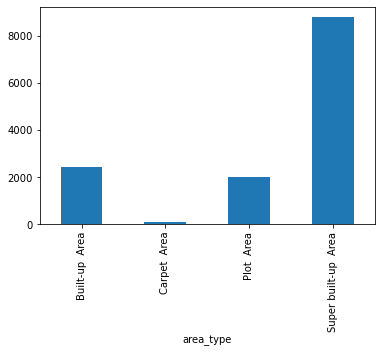

In [282]:
different_area = dataset.groupby('area_type')['area_type'].count()
different_area.plot(kind='bar')

### Removing Outlier

In [283]:
#counting different area
area_count = dataset.groupby('area_type')['area_type'].agg('count')
area_count

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [284]:
#unique area
dataset['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [285]:
# index of the 'Carpet  Area'
carpet_area_index = dataset[dataset.area_type=='Carpet  Area'].index
carpet_area_index

Int64Index([  297,   340,   352,   594,   622,   629,   642,  1020,  1033,
             1181,  1384,  1420,  1484,  1499,  1605,  1776,  1837,  2087,
             2228,  2756,  2816,  2923,  2932,  3249,  3250,  3341,  3412,
             3424,  3471,  3738,  4061,  4091,  4190,  4237,  4288,  4585,
             4611,  4620,  4853,  4966,  5099,  5153,  5238,  5518,  5709,
             6400,  6862,  7200,  7616,  7911,  7915,  7926,  8140,  8153,
             8248,  8413,  8527,  8597,  8837,  8890,  9245,  9285,  9319,
             9392,  9489,  9734,  9824, 10466, 10541, 10683, 10725, 10791,
            10796, 10899, 10907, 10935, 11502, 11543, 12238, 12398, 12531,
            12882, 13006, 13183, 13214, 13238, 13305],
           dtype='int64')

In [286]:
# dropping some rows those carrry 'Carpet  Area'
dataset.drop(carpet_area_index, axis=0, inplace=True)

In [287]:
#count every location
society_count = dataset.groupby('society')['society'].agg('count').sort_values(ascending=False)
society_count

society
GrrvaGr    5549
PrarePa      76
Sryalan      59
Prtates      59
GMown E      56
           ... 
ShtalCr       1
Leate O       1
ShstaAl       1
Shsom B       1
NDivaOl       1
Name: society, Length: 2669, dtype: int64

In [288]:
#society that appear less than 10
less_ten = society_count[society_count<5]
len(less_ten)


2330

In [289]:
#changing those society with are appear less than 10
dataset['location'] = dataset['society'].apply(lambda x:'other_society' if x in less_ten else x)
dataset['location'].nunique()

340

In [290]:
#outlier compared to bath and Num_bed_room
bath_bed = dataset[dataset.bath>dataset.Num_bed_room+2]
bath_bed

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room,location
1078,Plot Area,Srvasks,3300.0,14,1,50000000.0,9,other_society
1953,Plot Area,GrrvaGr,1200.0,12,1,11000000.0,8,GrrvaGr
1979,Plot Area,GrrvaGr,990.0,12,0,12000000.0,8,GrrvaGr
2620,Super built-up Area,Prowshi,11338.0,9,1,100000000.0,6,Prowshi
6838,Super built-up Area,GrrvaGr,7500.0,8,3,170000000.0,5,GrrvaGr
6937,Plot Area,GrrvaGr,2600.0,12,1,67500000.0,9,GrrvaGr
7709,Built-up Area,GrrvaGr,2460.0,7,2,8000000.0,4,GrrvaGr
8106,Plot Area,GrrvaGr,1850.0,12,1,30000000.0,8,GrrvaGr
9974,Plot Area,GrrvaGr,2400.0,6,2,77500000.0,3,GrrvaGr
9990,Plot Area,GrrvaGr,1200.0,9,3,12200000.0,6,GrrvaGr


In [291]:
#dropping rows
dataset.drop(bath_bed.index, axis=0, inplace=True)
dataset.shape

(13217, 8)

In [292]:
dataset.drop('location', axis=1, inplace=True)

In [293]:
dataset.head()

,area_type,society,total_sqft,bath,balcony,price,Num_bed_room
0,Super built-up Area,Coomee,1056.0,2,1,3907000.0,2
1,Plot Area,Theanmp,2600.0,5,3,12000000.0,4
2,Built-up Area,GrrvaGr,1440.0,2,3,6200000.0,3
3,Super built-up Area,Soiewre,1521.0,3,1,9500000.0,3
4,Super built-up Area,GrrvaGr,1200.0,2,1,5100000.0,2


In [294]:
dataset.dtypes

area_type        object
society          object
total_sqft      float64
bath              int64
balcony           int64
price           float64
Num_bed_room      int64
dtype: object

### Creating dummies column of categorical column

In [295]:
dataset = pd.get_dummies(dataset)
dataset.head()


,total_sqft,bath,balcony,price,Num_bed_room,area_type_Built-up Area,area_type_Plot Area,area_type_Super built-up Area,society_3Codeli,society_7 ise P,...,society_Xeitaa,society_YCnce R,society_YMhenLi,society_Yaenti,society_ZeodsWo,society_Zonce E,society_Zostaa,society_i1ncyRe,society_i1odsne,society_i1rtsCo
0,1056.0,2,1,3907000.0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2600.0,5,3,12000000.0,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1440.0,2,3,6200000.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1521.0,3,1,9500000.0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1200.0,2,1,5100000.0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
dataset.dropna(axis=0, inplace=True)

In [297]:
dataset.shape

(13212, 2676)

### Selecting Feature and Label data¶

In [298]:
X = dataset.drop('price', axis=1)
y = dataset['price']
print("Shape of X is :", X.shape)
print("Shape of y is :", y.shape)

Shape of X is : (13212, 2675)
Shape of y is : (13212,)


### Dividing dataset for train and test

In [299]:
Xtrain,xtest, Ytrain,ytest = train_test_split(X,y, test_size=.25, random_state=42)

In [300]:
print(Xtrain.shape, xtest.shape, Ytrain.shape, ytest.shape)

(9909, 2675) (3303, 2675) (9909,) (3303,)


### RanodmForestRegressor with Hyperparameter Tuning

In [31]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [32]:
rf = RandomForestRegressor()

In [33]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, 
                               n_jobs = -1)


In [34]:
# Fitting the data for hyperparameter 
rf_random.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 225.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 450.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [35]:
# Best parameter
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

### Training

In [38]:
rfr = RandomForestRegressor(n_estimators= 200,
                            min_samples_split= 5,
                            min_samples_leaf= 4,
                            max_features= 'auto',
                            max_depth= 10,
                            bootstrap= True)

In [39]:
rfr.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [41]:
predicted = rfr.predict(xtest)
predicted

array([ 5818151.41889108,  9007571.64854109, 21932581.33942134, ...,
        4624393.34069777,  5283969.37263611,  8374167.57116255])

### Checking Performance

In [53]:
mae = mean_absolute_error(ytest, predicted)
mae

3673315.8295332706

<AxesSubplot:xlabel='price', ylabel='Density'>

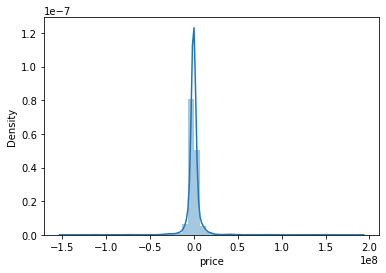

In [43]:
# checking predicted accuracy 
sns.distplot(ytest-predicted)

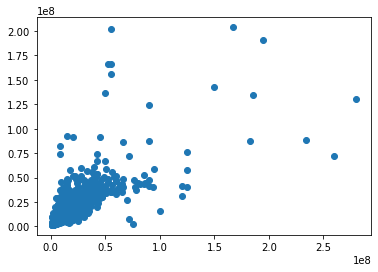

In [44]:
# checking predicted accuracy using scatter plot
plt.scatter(ytest,predicted)

### XGBRegressor with Hyperparameter Tuning

In [40]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

In [41]:
xgb_model = xgboost.XGBRegressor()

In [42]:
gsearch = GridSearchCV(estimator = xgb_model,
                        param_grid = param_tuning,                        
                        #scoring = 'neg_mean_absolute_error', #MAE 
                        #scoring = 'neg_mean_squared_error',  #MSE
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)


In [43]:
gsearch.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 142.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 439.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 874.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 1535.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 1953.8min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [44]:
gsearch.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

### Model

In [45]:
xgb_model = xgboost.XGBRegressor(
             colsample_bytree = 0.5,
             learning_rate = 0.01,
             max_depth = 10,
             min_child_weight = 1,
             n_estimators = 500,
             objective =  'reg:squarederror',
             subsample = 0.7)

In [46]:
xgb_model.fit(Xtrain, Ytrain) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
predicted = xgb_model.predict(xtest)
predicted

array([ 5868042. ,  7999073. , 19645656. , ...,  4662610.5,  5340758. ,
        8123123. ], dtype=float32)

### Plotting of the result

<AxesSubplot:xlabel='price', ylabel='Density'>

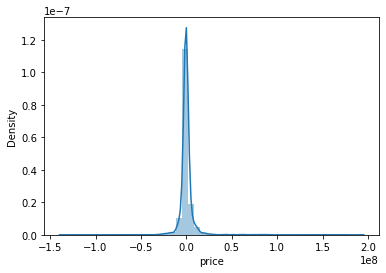

In [49]:
# checking predicted accuracy 
sns.distplot(ytest - predicted)

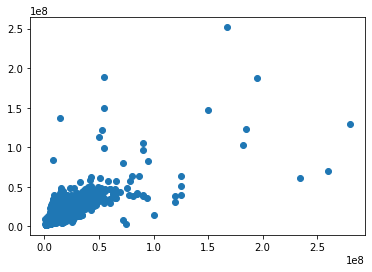

In [50]:
# checking predicted accuracy using scatter plot
plt.scatter(ytest, predicted)

In [53]:
# mean squared error
mse = mean_squared_error(ytest, predicted)
print("MSE: ", mse)


MSE:  92931687630853.55


### Model Saving

In [54]:
# save the model to disk
filename = 'flat_price.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

In [55]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

### Predicting with Totally New Data

In [74]:
def predict_price(area, society, total_sqft, bath, balcony, Num_bed_room):
    #total_sqft  bath   balcony   Num_bed_room
    loc_area = np.where(X.columns==area)[0]
    loc_society = np.where(X.columns==society)[0]
    
    x = np.zeros(3015)
    x[0] = total_sqft
    x[1] = bath 
    x[2] = balcony
    x[3] = Num_bed_room
    
    if (loc_area >= 0) and (loc_society >= 0):
        x[loc_area] = 1
        x[loc_society] = 1
    x = np.array(x).reshape((1, -1))
    return loaded_model.predict(x)
    

In [ ]:
predicted_price = predict_price('Super built-up Area', 'Theanmp', 1521, 3, 2, 3)

# Using Deep Learning

### Model

In [207]:
model = Sequential()
model.add(Dense(2675, input_dim=2675, kernel_initializer='normal', activation='relu'))
model.add(Dense(1500, kernel_initializer= 'normal', activation='relu'))
model.add(Dense(1, kernel_initializer= 'normal'))


In [208]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [209]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 2675)              7158300   
_________________________________________________________________
dense_16 (Dense)             (None, 1500)              4014000   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1501      
Total params: 11,173,801
Trainable params: 11,173,801
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [210]:
# fit model
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(xtest, ytest), 
                    epochs=100, 
                    verbose=0)


### Model Evaluation

In [211]:
# evaluate the model
train_mse = model.evaluate(Xtrain, Ytrain, verbose=0)
test_mse = model.evaluate(xtest, ytest, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 120379116879872.000, Test: 131172730404864.000


### Plotting Loss

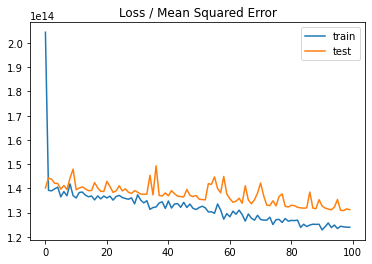

In [212]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Predicting

In [213]:
predicted = model.predict(xtest)
predicted

array([[ 7285397. ],
       [ 9076206. ],
       [19007098. ],
       ...,
       [ 5964710. ],
       [ 6580313.5],
       [ 9424692. ]], dtype=float32)

### Performance of predicted data

<AxesSubplot:xlabel='price', ylabel='Density'>

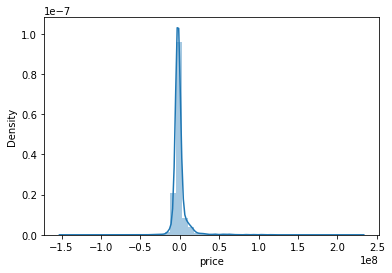

In [214]:
# checking predicted accuracy 
sns.distplot(ytest-predicted.flatten())

# Using PyTorch

In [302]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
xtest = np.array(xtest)
ytest = np.array(ytest)

Xtrain = torch.FloatTensor(Xtrain)
Ytrain = torch.FloatTensor(Ytrain)
xtest = torch.FloatTensor(xtest)
ytest = torch.FloatTensor(ytest)


### Model

In [334]:
class Model(nn.Module):
    def __init__(self, input_features=2675, hidden_layer1=3000, hidden_layer2=1500, output_features=1):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, hidden_layer2)
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x
    

In [335]:
Model = Model()
print(Model)

Model(
  (fc1): Linear(in_features=2675, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (out): Linear(in_features=1500, out_features=1, bias=True)
)


### Optimizer and Loss

In [336]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()  # this is for regression mean squared loss

### Training

In [337]:
epochs = 20
train_losses = []
valid_losses = []
train_correct = []
valid_correct = []

for epoch in range(epochs):
    out1 = Model.forward(Xtrain)
    train_loss = criterion(out1, Ytrain)
    train_losses.append(train_loss)
    
    out2 = Model.forward(xtest)
    valid_loss = criterion(out2, ytest)
    valid_losses.append(valid_loss)
    
    #print("Epoch {epoch:2}, Loss = {loss.item():10.8f}")

    optimizer.zero_grad()
    train_loss.backward()
    valid_loss.backward()
    optimizer.step()
    
    #train_correct += (out1 == Ytrain).float().sum()
    #valid_correct += (out2 == yvalid).float().sum()
    
    print(f'Epoch: {epoch:2}  Train_loss: {train_loss.item():10.8f}  Valid_loss:{valid_loss.item():10.8f} ')


Epoch:  0  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  1  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  2  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  3  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  4  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  5  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  6  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  7  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  8  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch:  9  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch: 10  Train_loss: 322182408306688.00000000  Valid_loss:357680682106880.00000000 
Epoch: 11  Train_loss: 322182408306688.00000000  Valid

### Predicting

In [332]:
predict_out = Model(xtest)
_, predict_y = torch.max(predict_out, 1)

In [ ]:
print('prediction accuracy :', accuracy_score(ytest.data, predict_y.data))